<a href="https://colab.research.google.com/github/laghuvarapuyogeshkumar/hotel-demand-pricing-agents-genai/blob/main/notebooks_Task8_Hotel_Demand_Pricing_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip -q install kaggle pandas numpy scikit-learn pyarrow


In [25]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [26]:
!kaggle datasets list | head


ref                                                                title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                           Heart Disease                                             3491  2025-12-11 15:29:14.327000           2114        348  1.0              
saidaminsaidaxmadov/chocolate-sales                                Chocolate Sales                                         468320  2026-01-04 14:23:35.490000              0         71  1.0              
aliiihussain/social-media-viral-content-and-engagement-metrics     Social Media Viral Content & Engagement Metrics          70865  2026-01-18 12:14:36.423000              0         27  1.0

In [27]:
!kaggle datasets download -d jessemostipak/hotel-booking-demand -p data/raw --unzip


Dataset URL: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 373MB/s]


Dataset URL: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 502MB/s]
Using dataset file: data/raw/hotel_bookings.csv


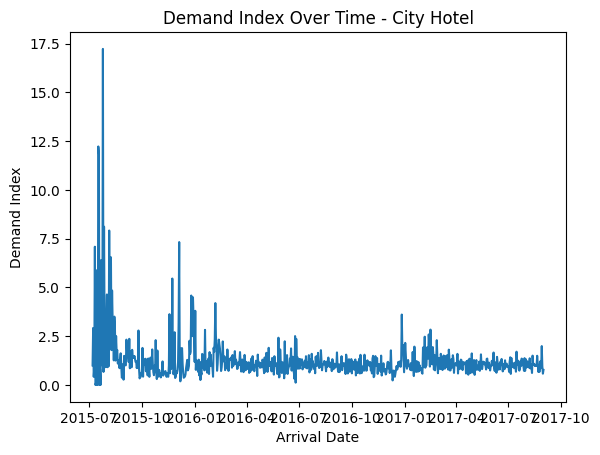

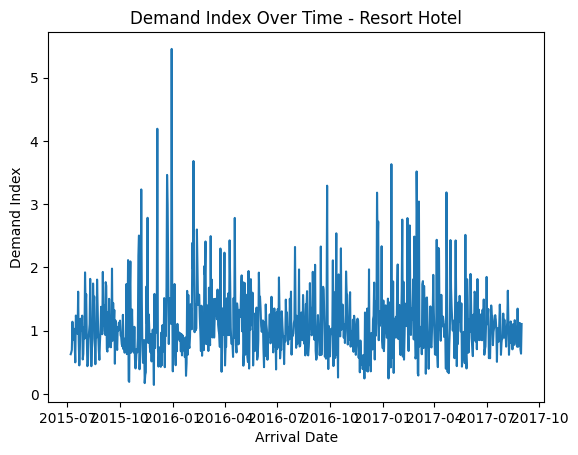

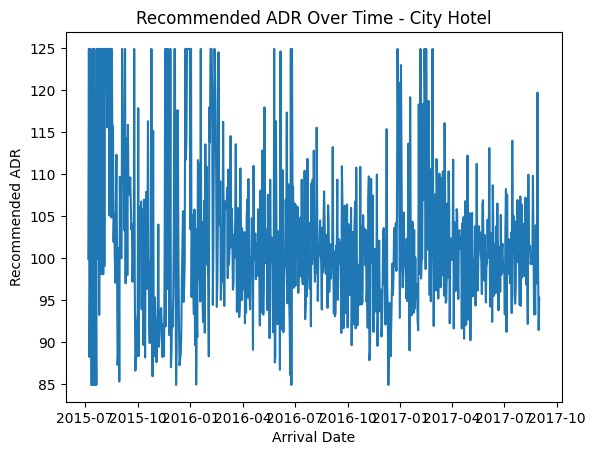

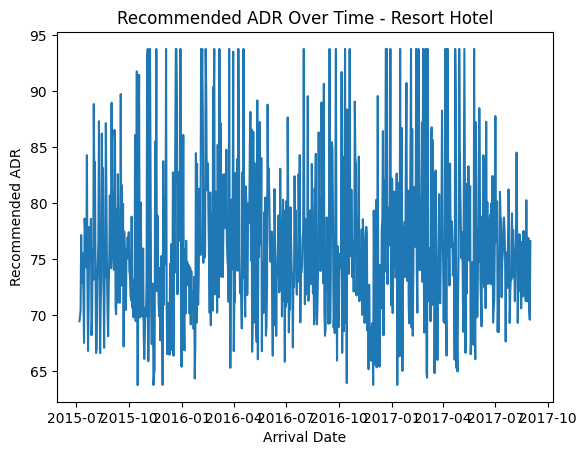


✅ Pipeline complete. Key outputs:
  - curated_parquet: data/curated_bookings.parquet
  - data_quality: outputs/data_quality.json
  - demand_by_date: outputs/demand_by_date.csv
  - price_recommendations: outputs/price_recommendations.csv
  - genai_explanations: outputs/genai_explanations.md

✅ Preview explanations:

# GenAI-style Pricing Explanations (Business Summary)

- **2015-07-07 | Resort Hotel**: Recommended ADR = **$69.43** (baseline **$75.00**). Demand index = **0.63** (~-37% vs 4-week baseline), so price is **adjusted lower** because demand is below the recent baseline (weaker booking pressure).
- **2015-07-07 | City Hotel**: Recommended ADR = **$99.90** (baseline **$99.90**). Demand index = **1.00** (~+0% vs 4-week baseline), so price is **kept close to baseline** because demand is roughly in line with recent trends.
- **2015-07-08 | City Hotel**: Recommended ADR = **$124.88** (baseline **$99.90**). Demand index = **2.92** (~+192% vs 4-week baseline), so price is **adjusted h

In [28]:
# =========================
# TASK-8: One-shot Colab Script (Updated)
# Hotel Demand + Pricing + Agents + GenAI-style Explanations
# =========================

# 0) Install packages
!pip -q install kaggle pandas numpy scikit-learn pyarrow matplotlib

import os
import json
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# -------------------------
# 1) Kaggle setup (expects kaggle.json uploaded to Colab working directory)
# -------------------------
if not os.path.exists("kaggle.json"):
    raise FileNotFoundError(
        "kaggle.json not found. Upload it in Colab (Files panel) then run again."
    )

os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# -------------------------
# 2) Download dataset
# -------------------------
os.makedirs("data/raw", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

!kaggle datasets download -d jessemostipak/hotel-booking-demand -p data/raw --unzip

# Find CSV (usually hotel_bookings.csv)
raw_files = os.listdir("data/raw")
csv_candidates = [f for f in raw_files if f.lower().endswith(".csv")]

if not csv_candidates:
    raise FileNotFoundError(f"No CSV found in data/raw. Found files: {raw_files}")

# Prefer hotel_bookings.csv if present
csv_candidates_sorted = sorted(csv_candidates, key=lambda x: (x.lower() != "hotel_bookings.csv", x))
csv_path = os.path.join("data/raw", csv_candidates_sorted[0])

print("Using dataset file:", csv_path)

# -------------------------
# 3) Agents
# -------------------------
class DataPrepAgent:
    def run(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        # Handle missing values
        if "children" in df.columns:
            df["children"] = df["children"].fillna(0)
        if "country" in df.columns:
            df["country"] = df["country"].fillna("UNKNOWN")
        if "agent" in df.columns:
            df["agent"] = df["agent"].fillna(-1)
        if "company" in df.columns:
            df["company"] = df["company"].fillna(-1)

        # Create arrival_date
        df["arrival_date"] = pd.to_datetime(
            df["arrival_date_year"].astype(str) + "-" +
            df["arrival_date_month"].astype(str) + "-" +
            df["arrival_date_day_of_month"].astype(str),
            errors="coerce"
        )

        # Feature engineering
        df["stay_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
        df["adj_room_nights"] = df["stay_nights"] * (1 - df["is_canceled"])

        # ADR sanity
        if "adr" in df.columns:
            df.loc[df["adr"] < 0, "adr"] = np.nan
            cap = df["adr"].quantile(0.99)
            df["adr"] = df["adr"].clip(upper=cap)

        # Save curated dataset (kept in /data for local run; do NOT commit large files)
        df.to_parquet("data/curated_bookings.parquet", index=False)

        # Data quality report
        dq = {
            "rows": int(df.shape[0]),
            "cols": int(df.shape[1]),
            "null_counts_top10": df.isna().sum().sort_values(ascending=False).head(10).to_dict(),
            "adr_99pct_cap": float(cap) if "adr" in df.columns else None,
            "arrival_date_nulls": int(df["arrival_date"].isna().sum())
        }
        with open("outputs/data_quality.json", "w") as f:
            json.dump(dq, f, indent=2)

        return df


class DemandAgent:
    def run(self, df: pd.DataFrame) -> pd.DataFrame:
        demand = (
            df.groupby(["arrival_date", "hotel"], dropna=False)
              .agg(demand=("adj_room_nights", "sum"))
              .reset_index()
              .sort_values("arrival_date")
        )

        # rolling 28-day median (min 7 days)
        demand["demand_index"] = (
            demand.groupby("hotel")["demand"]
                  .transform(lambda x: x / x.rolling(28, min_periods=7).median())
        )

        demand.to_csv("outputs/demand_by_date.csv", index=False)
        return demand


class PricingAgent:
    def __init__(self, min_adr=50, max_adr=500):
        self.min_adr = min_adr
        self.max_adr = max_adr

    def run(self, df: pd.DataFrame, demand_df: pd.DataFrame) -> pd.DataFrame:
        base_adr = (
            df.groupby("hotel")["adr"]
              .median()
              .reset_index(name="base_adr")
        )

        pricing = demand_df.merge(base_adr, on="hotel", how="left")

        # Adjustment factor based on demand index (safe caps)
        pricing["adj_factor"] = 1 + 0.2 * (pricing["demand_index"] - 1)
        pricing["adj_factor"] = pricing["adj_factor"].clip(0.85, 1.25)

        pricing["recommended_adr"] = pricing["base_adr"] * pricing["adj_factor"]
        pricing["recommended_adr"] = pricing["recommended_adr"].clip(self.min_adr, self.max_adr)

        pricing.to_csv("outputs/price_recommendations.csv", index=False)
        return pricing


class ExplainAgent:
    def run(self, pricing_df: pd.DataFrame, n=10) -> str:
        # Take first n non-null rows
        top = pricing_df.dropna(subset=["recommended_adr", "demand_index", "base_adr"]).head(n)

        explanations = []
        for _, row in top.iterrows():
            di = float(row["demand_index"])
            pct = (di - 1) * 100

            # 3-way explanation logic
            if di > 1.05:
                action = "adjusted higher"
                reason = "demand is above the recent baseline (more booking pressure)"
            elif di < 0.95:
                action = "adjusted lower"
                reason = "demand is below the recent baseline (weaker booking pressure)"
            else:
                action = "kept close to baseline"
                reason = "demand is roughly in line with recent trends"

            explanation = (
                f"- **{pd.to_datetime(row['arrival_date']).date()} | {row['hotel']}**: "
                f"Recommended ADR = **${row['recommended_adr']:.2f}** "
                f"(baseline **${row['base_adr']:.2f}**). "
                f"Demand index = **{di:.2f}** (~{pct:+.0f}% vs 4-week baseline), so price is **{action}** "
                f"because {reason}."
            )
            explanations.append(explanation)

        md = "# GenAI-style Pricing Explanations (Business Summary)\n\n" + "\n".join(explanations)

        with open("outputs/genai_explanations.md", "w") as f:
            f.write(md)

        return md


class OrchestratorAgent:
    def run(self, csv_path: str):
        df_raw = pd.read_csv(csv_path)

        df_clean = DataPrepAgent().run(df_raw)
        demand_df = DemandAgent().run(df_clean)
        pricing_df = PricingAgent(min_adr=50, max_adr=500).run(df_clean, demand_df)
        explanation_md = ExplainAgent().run(pricing_df, n=10)

        # Plots (simple, useful)
        for hotel in demand_df["hotel"].dropna().unique():
            tmp = demand_df[(demand_df["hotel"] == hotel)].dropna(subset=["demand_index"])
            if len(tmp) == 0:
                continue
            plt.figure()
            plt.plot(tmp["arrival_date"], tmp["demand_index"])
            plt.title(f"Demand Index Over Time - {hotel}")
            plt.xlabel("Arrival Date")
            plt.ylabel("Demand Index")
            plt.show()

        for hotel in pricing_df["hotel"].dropna().unique():
            tmp = pricing_df[(pricing_df["hotel"] == hotel)].dropna(subset=["recommended_adr"])
            if len(tmp) == 0:
                continue
            plt.figure()
            plt.plot(tmp["arrival_date"], tmp["recommended_adr"])
            plt.title(f"Recommended ADR Over Time - {hotel}")
            plt.xlabel("Arrival Date")
            plt.ylabel("Recommended ADR")
            plt.show()

        # Use timezone-aware UTC time (fixes deprecation warning)
        run_log = {
            "run_time_utc": str(datetime.datetime.now(datetime.timezone.utc)),
            "dataset_used": csv_path,
            "artifacts": {
                "curated_parquet": "data/curated_bookings.parquet",
                "data_quality": "outputs/data_quality.json",
                "demand_by_date": "outputs/demand_by_date.csv",
                "price_recommendations": "outputs/price_recommendations.csv",
                "genai_explanations": "outputs/genai_explanations.md",
            }
        }

        with open("outputs/run_log.json", "w") as f:
            json.dump(run_log, f, indent=2)

        print("\n✅ Pipeline complete. Key outputs:")
        for k, v in run_log["artifacts"].items():
            print(f"  - {k}: {v}")

        print("\n✅ Preview explanations:\n")
        print(explanation_md[:1500])


# -------------------------
# 4) Run everything
# -------------------------
OrchestratorAgent().run(csv_path)


In [29]:
!mkdir -p src/agents


In [30]:
%%writefile src/agents/prep_agent.py
# paste DataPrepAgent code here


Overwriting src/agents/prep_agent.py


In [31]:
!mkdir -p src/agents


In [32]:
%%writefile src/agents/prep_agent.py
import json
import numpy as np
import pandas as pd

class DataPrepAgent:
    def run(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        # Handle missing values
        df["children"] = df["children"].fillna(0)
        df["country"] = df["country"].fillna("UNKNOWN")
        df["agent"] = df["agent"].fillna(-1)
        df["company"] = df["company"].fillna(-1)

        # Create arrival_date
        df["arrival_date"] = pd.to_datetime(
            df["arrival_date_year"].astype(str) + "-" +
            df["arrival_date_month"].astype(str) + "-" +
            df["arrival_date_day_of_month"].astype(str),
            errors="coerce"
        )

        # Feature engineering
        df["stay_nights"] = (
            df["stays_in_weekend_nights"] +
            df["stays_in_week_nights"]
        )
        df["adj_room_nights"] = df["stay_nights"] * (1 - df["is_canceled"])

        # ADR sanity checks
        df.loc[df["adr"] < 0, "adr"] = np.nan
        adr_cap = df["adr"].quantile(0.99)
        df["adr"] = df["adr"].clip(upper=adr_cap)

        # Save curated dataset
        df.to_parquet("data/curated_bookings.parquet", index=False)

        # Data quality report
        dq_report = {
            "rows": int(df.shape[0]),
            "columns": int(df.shape[1]),
            "adr_99pct_cap": float(adr_cap),
            "top_null_columns": (
                df.isna().sum()
                  .sort_values(ascending=False)
                  .head(10)
                  .to_dict()
            )
        }

        with open("outputs/data_quality.json", "w") as f:
            json.dump(dq_report, f, indent=2)

        return df


Overwriting src/agents/prep_agent.py


**src/agents/demand_agent.py**

In [33]:
%%writefile src/agents/demand_agent.py
import pandas as pd

class DemandAgent:
    """
    Computes hotel demand by date using cancellation-adjusted room nights.
    Outputs a rolling demand index for each hotel.
    """
    def __init__(self, rolling_window: int = 28, min_periods: int = 7):
        self.rolling_window = rolling_window
        self.min_periods = min_periods

    def run(self, df: pd.DataFrame) -> pd.DataFrame:
        demand = (
            df.groupby(["arrival_date", "hotel"], dropna=False)
              .agg(demand=("adj_room_nights", "sum"))
              .reset_index()
              .sort_values("arrival_date")
        )

        demand["demand_index"] = (
            demand.groupby("hotel")["demand"]
                  .transform(lambda x: x / x.rolling(self.rolling_window, min_periods=self.min_periods).median())
        )

        demand.to_csv("outputs/demand_by_date.csv", index=False)
        return demand


Overwriting src/agents/demand_agent.py


**src/agents/pricing_agent.py**

In [34]:
%%writefile src/agents/pricing_agent.py
import pandas as pd

class PricingAgent:
    """
    Rule-based pricing recommendation:
    - baseline ADR = median ADR per hotel
    - adjust using demand_index with safe caps
    - enforce min/max ADR bounds
    """
    def __init__(self, min_adr: float = 50, max_adr: float = 500,
                 adj_sensitivity: float = 0.2, min_factor: float = 0.85, max_factor: float = 1.25):
        self.min_adr = min_adr
        self.max_adr = max_adr
        self.adj_sensitivity = adj_sensitivity
        self.min_factor = min_factor
        self.max_factor = max_factor

    def run(self, df: pd.DataFrame, demand_df: pd.DataFrame) -> pd.DataFrame:
        base_adr = (
            df.groupby("hotel")["adr"]
              .median()
              .reset_index(name="base_adr")
        )

        pricing = demand_df.merge(base_adr, on="hotel", how="left")

        pricing["adj_factor"] = 1 + self.adj_sensitivity * (pricing["demand_index"] - 1)
        pricing["adj_factor"] = pricing["adj_factor"].clip(self.min_factor, self.max_factor)

        pricing["recommended_adr"] = pricing["base_adr"] * pricing["adj_factor"]
        pricing["recommended_adr"] = pricing["recommended_adr"].clip(self.min_adr, self.max_adr)

        pricing.to_csv("outputs/price_recommendations.csv", index=False)
        return pricing


Overwriting src/agents/pricing_agent.py


**src/agents/explain_agent.py**

In [35]:
%%writefile src/agents/explain_agent.py
import pandas as pd

class ExplainAgent:
    """
    GenAI-style explanation agent (no API required).
    Converts pricing recommendations + demand signals into business language.
    """
    def __init__(self, high_threshold: float = 1.05, low_threshold: float = 0.95):
        self.high_threshold = high_threshold
        self.low_threshold = low_threshold

    def run(self, pricing_df: pd.DataFrame, n: int = 10) -> str:
        top = pricing_df.dropna(subset=["recommended_adr", "demand_index", "base_adr"]).head(n)

        explanations = []
        for _, row in top.iterrows():
            di = float(row["demand_index"])
            pct = (di - 1) * 100

            if di > self.high_threshold:
                action = "adjusted higher"
                reason = "demand is above the recent baseline (more booking pressure)"
            elif di < self.low_threshold:
                action = "adjusted lower"
                reason = "demand is below the recent baseline (weaker booking pressure)"
            else:
                action = "kept close to baseline"
                reason = "demand is roughly in line with recent trends"

            date_str = pd.to_datetime(row["arrival_date"]).date()
            hotel = row["hotel"]
            rec = float(row["recommended_adr"])
            base = float(row["base_adr"])

            explanations.append(
                f"- **{date_str} | {hotel}**: Recommended ADR = **${rec:.2f}** "
                f"(baseline **${base:.2f}**). Demand index = **{di:.2f}** (~{pct:+.0f}% vs 4-week baseline), "
                f"so price is **{action}** because {reason}."
            )

        md = "# GenAI-style Pricing Explanations (Business Summary)\n\n" + "\n".join(explanations)

        with open("outputs/genai_explanations.md", "w") as f:
            f.write(md)

        return md


Overwriting src/agents/explain_agent.py


**src/agents/orchestrator.py**

In [36]:
%%writefile src/agents/orchestrator.py
import os
import json
import datetime
import pandas as pd

from src.agents.prep_agent import DataPrepAgent
from src.agents.demand_agent import DemandAgent
from src.agents.pricing_agent import PricingAgent
from src.agents.explain_agent import ExplainAgent

class OrchestratorAgent:
    """
    Runs the full pipeline end-to-end:
      1) DataPrepAgent
      2) DemandAgent
      3) PricingAgent
      4) ExplainAgent
    Writes run log to outputs/run_log.json
    """
    def __init__(self, csv_path: str):
        self.csv_path = csv_path

    def run(self):
        os.makedirs("outputs", exist_ok=True)

        df_raw = pd.read_csv(self.csv_path)

        df_clean = DataPrepAgent().run(df_raw)
        demand_df = DemandAgent().run(df_clean)
        pricing_df = PricingAgent().run(df_clean, demand_df)
        ExplainAgent().run(pricing_df, n=10)

        run_log = {
            "run_time_utc": str(datetime.datetime.now(datetime.timezone.utc)),
            "dataset_used": self.csv_path,
            "artifacts": {
                "curated_parquet": "data/curated_bookings.parquet",
                "data_quality": "outputs/data_quality.json",
                "demand_by_date": "outputs/demand_by_date.csv",
                "price_recommendations": "outputs/price_recommendations.csv",
                "genai_explanations": "outputs/genai_explanations.md",
            }
        }

        with open("outputs/run_log.json", "w") as f:
            json.dump(run_log, f, indent=2)

        return run_log


Overwriting src/agents/orchestrator.py


In [37]:
!ls -R src/agents


src/agents:
demand_agent.py   orchestrator.py  pricing_agent.py
explain_agent.py  prep_agent.py    __pycache__

src/agents/__pycache__:
demand_agent.cpython-312.pyc   prep_agent.cpython-312.pyc
explain_agent.cpython-312.pyc  pricing_agent.cpython-312.pyc
orchestrator.cpython-312.pyc


In [38]:
from src.agents.orchestrator import OrchestratorAgent

csv_path = "data/raw/hotel_bookings.csv"
log = OrchestratorAgent(csv_path).run()
log


{'run_time_utc': '2026-01-22 04:49:57.308091+00:00',
 'dataset_used': 'data/raw/hotel_bookings.csv',
 'artifacts': {'curated_parquet': 'data/curated_bookings.parquet',
  'data_quality': 'outputs/data_quality.json',
  'demand_by_date': 'outputs/demand_by_date.csv',
  'price_recommendations': 'outputs/price_recommendations.csv',
  'genai_explanations': 'outputs/genai_explanations.md'}}